# Fully Connected Experiments on FashionMNIST with a standardized setup


## 1. Setup

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns

from copy import deepcopy
from IPython import display
from random import uniform

from semitorch import MaxPlus, maxplus_parameters, nonmaxplus_parameters
from semitorch import MinPlus, minplus_parameters, nonminplus_parameters
from semitorch import SemiLog, semilog_parameters, nonsemilog_parameters
from semitorch import TropicalSGD
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm.notebook import trange

data_path = os.path.abspath("./data" if os.path.isdir("./data") else "../data")
device = "cuda" if torch.cuda.is_available() else "cpu"

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.10.7
[Taichi] Starting on arch=cuda


### Load FashionMNIST data

In [2]:
batch_size = 256
num_workers = 8

transforms_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.286,), (0.353,)),
    ]
)

transforms_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.286,), (0.353,)),
    ]
)

fmnist_trainset = FashionMNIST(root=".", train=True, download=True, transform=transforms_train)
fmnist_testset = FashionMNIST(root=".", train=False, download=True, transform=transforms_test)

fmnist_trainloader = DataLoader(fmnist_trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
fmnist_testloader = DataLoader(fmnist_testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## 2. Models

In [3]:
class Model(nn.Module):
    def __init__(
            self,
            model_name: str,
            layer_norm: bool = False,
            skip_connections: bool = False,
            k: float = None,
            mu: float = None,
    ) -> None:
        super().__init__()
        self.name = model_name
        self.skip_connections = skip_connections

        self.stem = nn.Sequential(*list(filter(lambda layer: layer is not None, [
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=4, stride=4),
            nn.Flatten(),
            nn.LayerNorm(8 * 7 * 7) if layer_norm else None,
        ])))

        if model_name == "linear/relu":
            self.backbone_1 = nn.Sequential(
                nn.Linear(8 * 7 * 7, 300), nn.ReLU(),
                nn.Linear(300, 250), nn.ReLU(),
            )
            self.backbone_2 = nn.Sequential(
                nn.Linear(250 + (8 * 7 * 7 if self.skip_connections else 0), 200), nn.ReLU(),
                nn.Linear(200, 150), nn.ReLU(),
            )
            self.backbone_3 = nn.Sequential(
                nn.Linear(150 + (250 if self.skip_connections else 0), 100), nn.ReLU(),
                nn.Linear(100, 50), nn.ReLU(),
            )
        elif model_name == "linear/maxplus":
            self.backbone_1 = nn.Sequential(
                nn.Linear(8 * 7 * 7, 300),
                MaxPlus(300, 250, k=k),
            )
            self.backbone_2 = nn.Sequential(
                nn.Linear(250 + (8 * 7 * 7 if self.skip_connections else 0), 200),
                MaxPlus(200, 150, k=k),
            )
            self.backbone_3 = nn.Sequential(
                nn.Linear(150 + (250 if self.skip_connections else 0), 100),
                MaxPlus(100, 50, k=k),
            )
        elif model_name == "linear/minplus":
            self.backbone_1 = nn.Sequential(
                nn.Linear(8 * 7 * 7, 300),
                MinPlus(300, 250, k=k),
            )
            self.backbone_2 = nn.Sequential(
                nn.Linear(250 + (8 * 7 * 7 if self.skip_connections else 0), 200),
                MinPlus(200, 150, k=k),
            )
            self.backbone_3 = nn.Sequential(
                nn.Linear(150 + (250 if self.skip_connections else 0), 100),
                MinPlus(100, 50, k=k),
            )
        elif model_name == "linear/log":
            self.backbone_1 = nn.Sequential(
                nn.Linear(8 * 7 * 7, 300),
                SemiLog(300, 250, mu=mu),
            )
            self.backbone_2 = nn.Sequential(
                nn.Linear(250 + (8 * 7 * 7 if self.skip_connections else 0), 200),
                SemiLog(200, 150, mu=mu),
            )
            self.backbone_3 = nn.Sequential(
                nn.Linear(150 + (250 if self.skip_connections else 0), 100),
                SemiLog(100, 50, mu=mu),
            )
        else:
            raise RuntimeError(f"Unknown model ({model_name})")

        self.head = nn.Linear(50, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        input_0 = x
        result_0 = self.stem(input_0)

        input_1 = result_0
        result_1 = self.backbone_1(input_1)

        if self.skip_connections:
            input_2 = torch.cat((result_1, result_0), dim=-1)
        else:
            input_2 = result_1
        result_2 = self.backbone_2(input_2)

        if self.skip_connections:
            input_3 = torch.cat((result_2, result_1), dim=-1)
        else:
            input_3 = result_2
        result_3 = self.backbone_3(input_3)

        output = self.head(result_3)

        return output

In [4]:
def count_parameters(parameters) -> int:
    return sum(p.numel() for p in parameters if p.requires_grad)

## 3. Training

In [5]:
def accuracy(model: nn.Module, x: torch.Tensor, y: torch.Tensor) -> float:
    with torch.no_grad():
        yout = model(x)
        _, prediction = torch.max(yout.cpu(), dim=1)

        return (y.cpu() == prediction).sum().item() / float(y.numel())


def test(model: nn.Module, testloader: DataLoader) -> float:
    model.eval()
    accs = []

    with torch.no_grad():
        for x, y in testloader:
            x = x.to(device)
            accs.append(accuracy(model, x, y))

    return sum(accs) / len(accs)


def confusion_matrix(model: nn.Module, testloader: DataLoader) -> None:
    model.eval()

    conf_matrix = torch.zeros(len(fmnist_testset.classes), len(fmnist_testset.classes))

    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            yout = model(x)
            _, prediction = torch.max(yout.cpu(), dim=1)

            conf_matrix[y.cpu(), prediction] += 1

    plt.figure(figsize=(6, 4))

    df_cm = pd.DataFrame(conf_matrix, index=fmnist_testset.classes, columns=fmnist_testset.classes).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def train(
        model: nn.Module,
        trainloader: DataLoader,
        testloader: DataLoader,
        optimizers: list[torch.optim.Optimizer],
        schedulers: list[torch.optim.lr_scheduler],
        loss: torch.nn.modules.loss,
        epochs: int,
) -> None:
    accs = []  # list of accuracy on the test dataset for every epoch
    trainaccs = []  # a list of the accuracies of all the training batches

    fig, ax = plt.subplots(1, 1, figsize=[6, 4])
    hdisplay = display.display("", display_id=True)

    for _ in trange(epochs):
        model.train()

        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            for optimizer in optimizers:
                optimizer.zero_grad()
            yout = model(x)
            _, prediction = torch.max(yout.cpu(), dim=1)
            trainaccs.append((y.cpu() == prediction).sum().item() / float(y.numel()))

            l = loss(yout, y.squeeze())
            l.backward()
            for optimizer in optimizers:
                if isinstance(optimizer, TropicalSGD):
                    optimizer.step(input_tensor=x.cpu())
                else:
                    optimizer.step()

            for scheduler in schedulers:
                scheduler.step()

        accs.append(test(model, testloader))

        ax.clear()
        ax.set_xlim(0, epochs)
        ax.set_ylim(-0.02, 1.02)
        ax.plot(
            np.linspace(0, len(accs), len(trainaccs)),
            trainaccs,
            ".",
            markersize=1.5,
            markerfacecolor=(0, 0, 1, 0.3),
        )
        ax.plot(np.linspace(1, len(accs), len(accs)), accs)
        ax.text(
            0.6 * epochs,
            0.30,
            f"max test acc = {max(accs):.2%}",
            ha="center",
            fontsize=10,
        )
        hdisplay.update(fig)

        # prevents OOM when GPU memory is tight
        torch.cuda.empty_cache()
        gc.collect()

    confusion_matrix(model, testloader)

In [6]:
def run_model_for_config(config: dict, best_accuracy: float) -> dict:
    loss = nn.CrossEntropyLoss()
    epochs = 20

    # Create model
    model_name = config["model_name"]
    layer_norm = config["layer_norm"]
    skip_connections = config["skip_connections"]
    k = config["k"]
    mu = config["mu"]

    model = Model(model_name=model_name, layer_norm=layer_norm, skip_connections=skip_connections, k=k, mu=mu).to(device)

    # Separate model parameters
    if model_name == "linear/relu":
        linear_params = model.parameters()
        semiring_params = nn.ParameterList()
    elif model_name == "linear/maxplus":
        linear_params = nonmaxplus_parameters(model)
        semiring_params = maxplus_parameters(model)
    elif model_name == "linear/minplus":
        linear_params = nonminplus_parameters(model)
        semiring_params = minplus_parameters(model)
    elif model_name == "linear/log":
        linear_params = nonsemilog_parameters(model)
        semiring_params = semilog_parameters(model)
    else:
        raise RuntimeError(f"Unknown model ({model_name})")

    # Create linear optimizer
    linear_lr = config["linear_lr"]
    if config["linear_optimizer"] == "AdamW":
        linear_optimizer = torch.optim.AdamW(linear_params, lr=linear_lr, weight_decay=0.01)
    elif config["linear_optimizer"] == "SGD":
        linear_optimizer = torch.optim.SGD(linear_params, lr=linear_lr)
    else:
        raise RuntimeError(f'Unknown linear optimizer {config["linear_optimizer"]}')
    if config["linear_scheduler"]:
        linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            linear_optimizer,
            max_lr=linear_lr,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(fmnist_trainloader),
            epochs=epochs,
        )
    else:
        linear_scheduler = None

    # Create semiring optimizer
    semiring_lr = config["semiring_lr"]
    if config["semiring_optimizer"] is None:
        semiring_optimizer = None
    elif config["semiring_optimizer"] == "SGD":
        semiring_optimizer = torch.optim.SGD(semiring_params, lr=semiring_lr)
    elif config["semiring_optimizer"] == "TropicalSGD":
        semiring_optimizer = TropicalSGD(semiring_params, lr=semiring_lr)
    else:
        raise RuntimeError(f'Unknown semiring optimizer {config["semiring_optimizer"]}')
    if config["semiring_scheduler"]:
        semiring_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            semiring_optimizer,
            max_lr=semiring_lr,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(fmnist_trainloader),
            epochs=epochs,
        )
    else:
        semiring_scheduler = None

    # Create optimizers and schedulers
    optimizers = list(filter(lambda opt: opt is not None, [linear_optimizer, semiring_optimizer]))
    schedulers = list(filter(lambda sch: sch is not None, [linear_scheduler, semiring_scheduler]))

    report, reported_accuracy, last_reported_accuracy = [], 0, 0
    for epoch in range(epochs):
        last_reported_accuracy = reported_accuracy

        # Feed to training function
        reported_accuracy = train_model(
            model,
            fmnist_trainloader,
            fmnist_testloader,
            optimizers,
            schedulers,
            loss,
        )

        # Try some stopping conditions
        if ((epoch > 2) and (reported_accuracy < 0.15)) or ((epoch > 5) and (reported_accuracy < best_accuracy / 2)):
            # Bad trial
            return {"accuracy": reported_accuracy, "config": config}

        if (epoch > 2) and (abs(last_reported_accuracy - reported_accuracy) < 1e-6):
            # Run is done, no sense to train it any further
            break  # Break for-loop to report

    return {"accuracy": reported_accuracy, "config": config}


def train_model(
        model: nn.Module,
        trainloader: DataLoader,
        testloader: DataLoader,
        optimizers: list[torch.optim.Optimizer],
        schedulers: list[torch.optim.lr_scheduler],
        loss: torch.nn.modules.loss,
) -> float:
    model.train()

    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        for optimizer in optimizers:
            optimizer.zero_grad()

        l = loss(model(x), y.squeeze())
        l.backward()

        for optimizer in optimizers:
            if isinstance(optimizer, TropicalSGD):
                optimizer.step(input_tensor=x.cpu())
            else:
                optimizer.step()

        for scheduler in schedulers:
            scheduler.step()

        # prevents OOM when GPU memory is tight
        torch.cuda.empty_cache()
        gc.collect()

    return test(model, testloader)


def run_random_search_for_config(config: dict) -> dict:
    best_accuracy, best_config, current_config = 0, deepcopy(config), deepcopy(config)
    step_size, bad_step_counter, good_step_counter = 0.1, 0, 0
    for num_trial in range(100):
        result = run_model_for_config(current_config, best_accuracy=best_accuracy)

        if result["accuracy"] > best_accuracy:
            bad_step_counter = 0
            good_step_counter += 1

            best_accuracy, best_config = result["accuracy"], deepcopy(current_config)
        else:
            bad_step_counter += 1
            good_step_counter = 0

        if bad_step_counter > 10:
            break  # Terminate run, likely no better accuracy possible

        current_config, step_size, bad_step_counter, good_step_counter = adaptive_step_update_config(
            config=deepcopy(best_config),
            step_size=step_size,
            bad_step_counter=bad_step_counter,
            good_step_counter=good_step_counter,
        )

        if step_size < 1e-2:
            # Step size too small to make any impact, terminate run
            break

    return {"accuracy": best_accuracy, "config": best_config}


def adaptive_step_update_config(
        config: dict,
        step_size: float,
        bad_step_counter: int,
        good_step_counter: int,
) -> tuple[dict, float, int, int]:
    # Update step_size
    if bad_step_counter > 2:
        step_size /= 2
        bad_step_counter = 0
    if (good_step_counter > 2) and (step_size < 0.5):
        step_size *= 2
        good_step_counter = 0

    # Update config values
    if config["model_name"] == "linear/relu":
        config["linear_lr"] = uniform(
            config["linear_lr"] * (1 - step_size),
            config["linear_lr"] * (1 + step_size),
        )
    if (config["model_name"] == "linear/maxplus") or (config["model_name"] == "linear/minplus"):
        config["k"] = uniform(
            config["k"] * (1 - step_size),
            config["k"] * (1 + step_size),
        )
    if config["model_name"] != "linear/relu":
        config["semiring_lr"] = uniform(
            config["semiring_lr"] * (1 - step_size),
            config["semiring_lr"] * (1 + step_size),
        )
    if config["model_name"] == "linear/log":
        config["mu"] = uniform(
            config["mu"] * (1 - step_size),
            config["mu"] * (1 + step_size),
        )

    return config, step_size, bad_step_counter, good_step_counter


def find_best_model_for(config: dict) -> None:
    current_config, results = deepcopy(config), []
    
    if config["model_name"] == "linear/relu":
        for linear_optimizer in config["linear_optimizer"]:
            current_config["linear_optimizer"] = linear_optimizer
            for linear_scheduler in config["linear_scheduler"]:
                current_config["linear_scheduler"] = linear_scheduler
                
                print(f"Starting linear run for config {current_config}")
                results.append(run_random_search_for_config(current_config))
    else:
        for semiring_optimizer in config["semiring_optimizer"]:
            current_config["semiring_optimizer"] = semiring_optimizer
            if semiring_optimizer == "TropicalSGD":
                # TropicalSGD does not support momentum and cycle-momentum
                # Both are necessary for one-cycle scheduler
                print(f"Starting semiring run for config {current_config}")
                results.append(run_random_search_for_config(current_config))
            else:
                for semiring_scheduler in config["semiring_scheduler"]:
                    current_config["semiring_scheduler"] = semiring_scheduler

                    print(f"Starting semiring run for config {current_config}")
                    results.append(run_random_search_for_config(current_config))

    sorted_results = sorted(results, key=lambda dictionary: dictionary["accuracy"], reverse=True)

    display.clear_output(wait=True)
    print(f'Best trial config with accuracy of {sorted_results[0]["accuracy"]}: {sorted_results[0]["config"]}')
    print(f"-----------------")
    print(*sorted_results, sep="\n")

# Default Linear Models

In [7]:
find_best_model_for(config={
    "model_name": "linear/relu",
    "layer_norm": True,
    "skip_connections": True,
    "k": None,
    "linear_optimizer": ["AdamW", "SGD"],
    "linear_scheduler": [True, False],
    "linear_lr": 10 ** uniform(-3, -1),
    "semiring_lr": None,
    "semiring_optimizer": None,
    "semiring_scheduler": None,
    "mu": None,
})

Best trial config with accuracy of 0.89921875: {'model_name': 'linear/relu', 'layer_norm': True, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.017918412376152725, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None}
-----------------
{'accuracy': 0.89921875, 'config': {'model_name': 'linear/relu', 'layer_norm': True, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.017918412376152725, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None}}
{'accuracy': 0.89287109375, 'config': {'model_name': 'linear/relu', 'layer_norm': True, 'skip_connections': True, 'k': None, 'linear_optimizer': 'SGD', 'linear_scheduler': True, 'linear_lr': 0.019030593603853313, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None}}
{'accuracy': 0.8654296875, 'config': {'model_name': 'linear/relu', 'layer_norm': True, 'skip_connect

In [10]:
find_best_model_for(config={
    "model_name": "linear/relu",
    "layer_norm": True,
    "skip_connections": False,
    "k": None,
    "linear_optimizer": ["AdamW", "SGD"],
    "linear_scheduler": [True, False],
    "linear_lr": 10 ** uniform(-3, -1),
    "semiring_lr": None,
    "semiring_optimizer": None,
    "semiring_scheduler": None,
    "mu": None,
})

Best trial config with accuracy of 0.89765625: {'model_name': 'linear/relu', 'layer_norm': True, 'skip_connections': False, 'k': None, 'linear_optimizer': 'SGD', 'linear_scheduler': True, 'linear_lr': 0.07765284287150637, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None}
-----------------
{'accuracy': 0.89765625, 'config': {'model_name': 'linear/relu', 'layer_norm': True, 'skip_connections': False, 'k': None, 'linear_optimizer': 'SGD', 'linear_scheduler': True, 'linear_lr': 0.07765284287150637, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None}}
{'accuracy': 0.8830078125, 'config': {'model_name': 'linear/relu', 'layer_norm': True, 'skip_connections': False, 'k': None, 'linear_optimizer': 'SGD', 'linear_scheduler': False, 'linear_lr': 0.07634842734299482, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None}}
{'accuracy': 0.09765625, 'config': {'model_name': 'linear/relu', 'layer_norm': True, 'skip_connections':

In [11]:
find_best_model_for(config={
    "model_name": "linear/relu",
    "layer_norm": False,
    "skip_connections": True,
    "k": None,
    "linear_optimizer": ["AdamW", "SGD"],
    "linear_scheduler": [True, False],
    "linear_lr": 10 ** uniform(-3, -1),
    "semiring_lr": None,
    "semiring_optimizer": None,
    "semiring_scheduler": None,
    "mu": None,
})

Best trial config with accuracy of 0.8994140625: {'model_name': 'linear/relu', 'layer_norm': False, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None}
-----------------
{'accuracy': 0.8994140625, 'config': {'model_name': 'linear/relu', 'layer_norm': False, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None}}
{'accuracy': 0.8919921875, 'config': {'model_name': 'linear/relu', 'layer_norm': False, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': False, 'linear_lr': 0.002402080339212877, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None}}
{'accuracy': 0.88388671875, 'config': {'model_name': 'linear/relu', 'layer_norm': False, 's

In [12]:
find_best_model_for(config={
    "model_name": "linear/relu",
    "layer_norm": False,
    "skip_connections": False,
    "k": None,
    "linear_optimizer": ["AdamW", "SGD"],
    "linear_scheduler": [True, False],
    "linear_lr": 10 ** uniform(-3, -1),
    "semiring_lr": None,
    "semiring_optimizer": None,
    "semiring_scheduler": None,
    "mu": None,
})

Best trial config with accuracy of 0.89541015625: {'model_name': 'linear/relu', 'layer_norm': False, 'skip_connections': False, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.0016964332308704894, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None}
-----------------
{'accuracy': 0.89541015625, 'config': {'model_name': 'linear/relu', 'layer_norm': False, 'skip_connections': False, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.0016964332308704894, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None}}
{'accuracy': 0.89150390625, 'config': {'model_name': 'linear/relu', 'layer_norm': False, 'skip_connections': False, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': False, 'linear_lr': 0.0017863762894369068, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None}}
{'accuracy': 0.65703125, 'config': {'model_name': 'linear/relu', 'layer_norm': Fal

Best linear model

linear/relu model has 397686 trainable parameters


''

  0%|          | 0/20 [00:00<?, ?it/s]

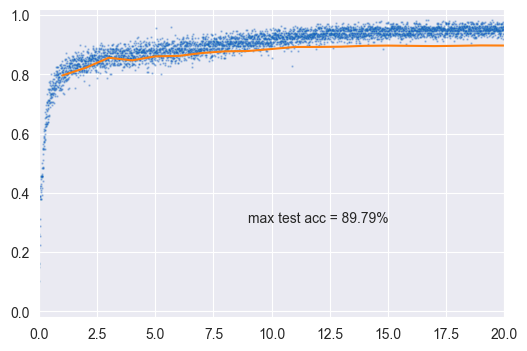

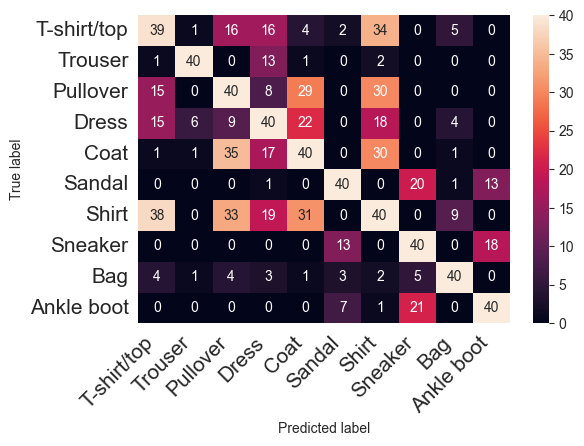

In [13]:
best_linear_model = Model(model_name="linear/relu", layer_norm=False, skip_connections=True).to(device)
print(f"{best_linear_model.name} model has {count_parameters(best_linear_model.parameters())} trainable parameters")

best_linear_optimizer = torch.optim.AdamW(best_linear_model.parameters(), lr=0.002191529436858294, weight_decay=0.01)
best_linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    best_linear_optimizer,
    max_lr=0.002191529436858294,
    anneal_strategy="linear",
    pct_start=0.3,
    three_phase=True,
    final_div_factor=1000.0,
    div_factor=10.0,
    steps_per_epoch=len(fmnist_trainloader),
    epochs=20,
)

train(
    best_linear_model,
    fmnist_trainloader,
    fmnist_testloader,
    [best_linear_optimizer],
    [best_linear_scheduler],
    nn.CrossEntropyLoss(),
    20,
)

# Tropical models

MaxPlus

In [7]:
find_best_model_for(config={
    "model_name": "linear/maxplus",
    "layer_norm": True,
    "skip_connections": False,
    "k": uniform(1, 3),
    "linear_optimizer": "AdamW",
    "linear_scheduler": True,
    "linear_lr": 0.002191529436858294,
    "semiring_lr": 10 ** uniform(-3, -2),
    "semiring_optimizer": ["SGD", "TropicalSGD"],
    "semiring_scheduler": [True, False],
    "mu": None,
})

Best trial config with accuracy of 0.858984375: {'model_name': 'linear/maxplus', 'layer_norm': True, 'skip_connections': False, 'k': 1.4196739160182044, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.008066274014326158, 'semiring_optimizer': 'SGD', 'semiring_scheduler': False}
-----------------
{'accuracy': 0.858984375, 'config': {'model_name': 'linear/maxplus', 'layer_norm': True, 'skip_connections': False, 'k': 1.4196739160182044, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.008066274014326158, 'semiring_optimizer': 'SGD', 'semiring_scheduler': False}}
{'accuracy': 0.7796875, 'config': {'model_name': 'linear/maxplus', 'layer_norm': True, 'skip_connections': False, 'k': 1.4535519607048097, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.007541017143730398, 'semiring_optimizer': 'TropicalSGD', 'semiring_sche

In [8]:
find_best_model_for(config={
    "model_name": "linear/maxplus",
    "layer_norm": False,
    "skip_connections": False,
    "k": uniform(1, 3),
    "linear_optimizer": "AdamW",
    "linear_scheduler": True,
    "linear_lr": 0.002191529436858294,
    "semiring_lr": 10 ** uniform(-3, -2),
    "semiring_optimizer": ["SGD", "TropicalSGD"],
    "semiring_scheduler": [True, False],
    "mu": None,
})

Best trial config with accuracy of 0.8787109375: {'model_name': 'linear/maxplus', 'layer_norm': False, 'skip_connections': False, 'k': 1.6779795124343204, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.0014937538069069872, 'semiring_optimizer': 'SGD', 'semiring_scheduler': True}
-----------------
{'accuracy': 0.8787109375, 'config': {'model_name': 'linear/maxplus', 'layer_norm': False, 'skip_connections': False, 'k': 1.6779795124343204, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.0014937538069069872, 'semiring_optimizer': 'SGD', 'semiring_scheduler': True}}
{'accuracy': 0.87822265625, 'config': {'model_name': 'linear/maxplus', 'layer_norm': False, 'skip_connections': False, 'k': 1.32355872778876, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.0014279014665088416, 'semiring_optimizer': 'TropicalSGD', 'semir

In [7]:
find_best_model_for(config={
    "model_name": "linear/maxplus",
    "layer_norm": True,
    "skip_connections": True,
    "k": uniform(1, 3),
    "linear_optimizer": "AdamW",
    "linear_scheduler": True,
    "linear_lr": 0.002191529436858294,
    "semiring_lr": 10 ** uniform(-3, -2),
    "semiring_optimizer": ["SGD", "TropicalSGD"],
    "semiring_scheduler": [True, False],
    "mu": None,
})

Best trial config with accuracy of 0.8890625: {'model_name': 'linear/maxplus', 'layer_norm': True, 'skip_connections': True, 'k': 2.1228529379677457, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.0022368032143443403, 'semiring_optimizer': 'TropicalSGD', 'semiring_scheduler': False, 'mu': None}
-----------------
{'accuracy': 0.8890625, 'config': {'model_name': 'linear/maxplus', 'layer_norm': True, 'skip_connections': True, 'k': 2.1228529379677457, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.0022368032143443403, 'semiring_optimizer': 'TropicalSGD', 'semiring_scheduler': False, 'mu': None}}
{'accuracy': 0.8861328125, 'config': {'model_name': 'linear/maxplus', 'layer_norm': True, 'skip_connections': True, 'k': 2.2679782380746953, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.0021213619106647936, 'semiring_op

In [7]:
find_best_model_for(config={
    "model_name": "linear/maxplus",
    "layer_norm": False,
    "skip_connections": True,
    "k": uniform(1, 3),
    "linear_optimizer": "AdamW",
    "linear_scheduler": True,
    "linear_lr": 0.002191529436858294,
    "semiring_lr": 10 ** uniform(-3, -2),
    "semiring_optimizer": ["SGD", "TropicalSGD"],
    "semiring_scheduler": [True, False],
    "mu": None,
})

Best trial config with accuracy of 0.88759765625: {'model_name': 'linear/maxplus', 'layer_norm': False, 'skip_connections': True, 'k': 2.317355027179237, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.004047819320849319, 'semiring_optimizer': 'TropicalSGD', 'semiring_scheduler': False, 'mu': None}
-----------------
{'accuracy': 0.88759765625, 'config': {'model_name': 'linear/maxplus', 'layer_norm': False, 'skip_connections': True, 'k': 2.317355027179237, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.004047819320849319, 'semiring_optimizer': 'TropicalSGD', 'semiring_scheduler': False, 'mu': None}}
{'accuracy': 0.8845703125, 'config': {'model_name': 'linear/maxplus', 'layer_norm': False, 'skip_connections': True, 'k': 2.7689757921195226, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.004715233054817645, 'semir

Best MaxPlus model

linear/maxplus model has 398470 trainable parameters, of which 288020 are linear and 110450 are semiring related


''

  0%|          | 0/20 [00:00<?, ?it/s]

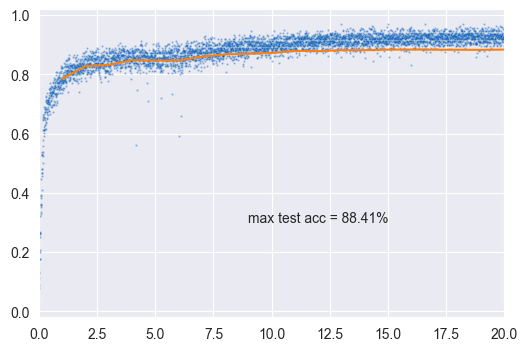

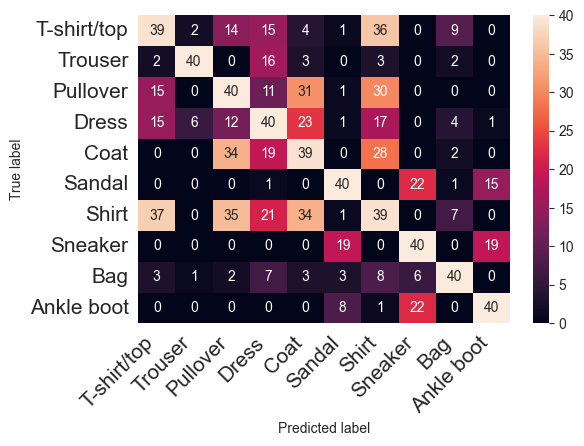

In [7]:
best_maxplus_model = Model("linear/maxplus", layer_norm=True, skip_connections=True, k=2.1228529379677457).to(device)
    
print(f"{best_maxplus_model.name} model has {count_parameters(best_maxplus_model.parameters())} trainable parameters, "
      f"of which {count_parameters(nonmaxplus_parameters(best_maxplus_model))} are linear "
      f"and {count_parameters(maxplus_parameters(best_maxplus_model))} are semiring related")

best_maxplus_linear_optimizer = torch.optim.AdamW(nonmaxplus_parameters(best_maxplus_model), lr=0.002191529436858294, weight_decay=0.01)
best_maxplus_linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    best_maxplus_linear_optimizer,
    max_lr=0.002191529436858294,
    anneal_strategy="linear",
    pct_start=0.3,
    three_phase=True,
    final_div_factor=1000.0,
    div_factor=10.0,
    steps_per_epoch=len(fmnist_trainloader),
    epochs=20,
)
best_maxplus_semiring_optimizer = TropicalSGD(maxplus_parameters(best_maxplus_model), lr=0.0022368032143443403)

best_maxplus_optimizers = [best_maxplus_linear_optimizer, best_maxplus_semiring_optimizer]
best_maxplus_schedulers = [best_maxplus_linear_scheduler]

train(
    best_maxplus_model,
    fmnist_trainloader,
    fmnist_testloader,
    best_maxplus_optimizers,
    best_maxplus_schedulers,
    nn.CrossEntropyLoss(),
    20,
)

MinPlus

In [7]:
find_best_model_for(config={
    "model_name": "linear/minplus",
    "layer_norm": True,
    "skip_connections": False,
    "k": uniform(1, 3),
    "linear_optimizer": "AdamW",
    "linear_scheduler": True,
    "linear_lr": 0.002191529436858294,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["SGD", "TropicalSGD"],
    "semiring_scheduler": [True, False],
    "mu": None,
})

Best trial config with accuracy of 0.88525390625: {'model_name': 'linear/minplus', 'layer_norm': True, 'skip_connections': False, 'k': 1.7021040580942977, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.006141250650465798, 'semiring_optimizer': 'TropicalSGD', 'semiring_scheduler': False}
-----------------
{'accuracy': 0.88525390625, 'config': {'model_name': 'linear/minplus', 'layer_norm': True, 'skip_connections': False, 'k': 1.7021040580942977, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.006141250650465798, 'semiring_optimizer': 'TropicalSGD', 'semiring_scheduler': False}}
{'accuracy': 0.8796875, 'config': {'model_name': 'linear/minplus', 'layer_norm': True, 'skip_connections': False, 'k': 1.62979271875319, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.006374167517215385, 'semiring_optimizer': 'SGD', 'sem

In [8]:
find_best_model_for(config={
    "model_name": "linear/minplus",
    "layer_norm": False,
    "skip_connections": False,
    "k": uniform(1, 3),
    "linear_optimizer": "AdamW",
    "linear_scheduler": True,
    "linear_lr": 0.002191529436858294,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["SGD", "TropicalSGD"],
    "semiring_scheduler": [True, False],
    "mu": None,
})

Best trial config with accuracy of 0.89013671875: {'model_name': 'linear/minplus', 'layer_norm': False, 'skip_connections': False, 'k': 1.3193440362446622, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.0017314799885488064, 'semiring_optimizer': 'TropicalSGD', 'semiring_scheduler': False}
-----------------
{'accuracy': 0.89013671875, 'config': {'model_name': 'linear/minplus', 'layer_norm': False, 'skip_connections': False, 'k': 1.3193440362446622, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.0017314799885488064, 'semiring_optimizer': 'TropicalSGD', 'semiring_scheduler': False}}
{'accuracy': 0.8767578125, 'config': {'model_name': 'linear/minplus', 'layer_norm': False, 'skip_connections': False, 'k': 1.505948510759822, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.00137691092570825, 'semiring_optimizer': 'SG

In [8]:
find_best_model_for(config={
    "model_name": "linear/minplus",
    "layer_norm": True,
    "skip_connections": True,
    "k": uniform(1, 3),
    "linear_optimizer": "AdamW",
    "linear_scheduler": True,
    "linear_lr": 0.002191529436858294,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["SGD", "TropicalSGD"],
    "semiring_scheduler": [True, False],
    "mu": None,
})

Best trial config with accuracy of 0.8912109375: {'model_name': 'linear/minplus', 'layer_norm': True, 'skip_connections': True, 'k': 2.386327233946164, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.0029943956377409533, 'semiring_optimizer': 'SGD', 'semiring_scheduler': False, 'mu': None}
-----------------
{'accuracy': 0.8912109375, 'config': {'model_name': 'linear/minplus', 'layer_norm': True, 'skip_connections': True, 'k': 2.386327233946164, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.0029943956377409533, 'semiring_optimizer': 'SGD', 'semiring_scheduler': False, 'mu': None}}
{'accuracy': 0.8908203125, 'config': {'model_name': 'linear/minplus', 'layer_norm': True, 'skip_connections': True, 'k': 2.2240345845344267, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.002708342017803174, 'semiring_optimizer': 'SG

In [7]:
find_best_model_for(config={
    "model_name": "linear/minplus",
    "layer_norm": False,
    "skip_connections": True,
    "k": uniform(1, 3),
    "linear_optimizer": "AdamW",
    "linear_scheduler": True,
    "linear_lr": 0.002191529436858294,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["SGD", "TropicalSGD"],
    "semiring_scheduler": [True, False],
    "mu": None,
})

Best trial config with accuracy of 0.8912109375: {'model_name': 'linear/minplus', 'layer_norm': False, 'skip_connections': True, 'k': 2.248594860324228, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.010669512911743487, 'semiring_optimizer': 'SGD', 'semiring_scheduler': False, 'mu': None}
-----------------
{'accuracy': 0.8912109375, 'config': {'model_name': 'linear/minplus', 'layer_norm': False, 'skip_connections': True, 'k': 2.248594860324228, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.010669512911743487, 'semiring_optimizer': 'SGD', 'semiring_scheduler': False, 'mu': None}}
{'accuracy': 0.88857421875, 'config': {'model_name': 'linear/minplus', 'layer_norm': False, 'skip_connections': True, 'k': 2.5015725333081407, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.011910832653112716, 'semiring_optimizer': '

Best MinPlus model

linear/minplus model has 398470 trainable parameters, of which 288020 are linear and 110450 are semiring related


''

  0%|          | 0/20 [00:00<?, ?it/s]

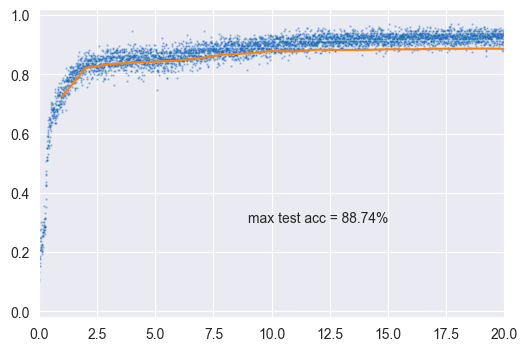

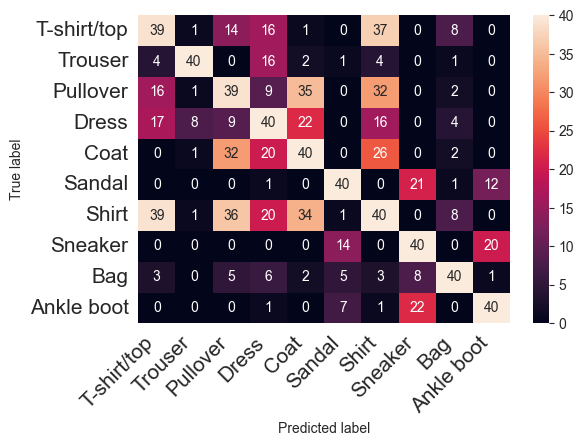

In [10]:
best_minplus_model = Model("linear/minplus", layer_norm=True, skip_connections=True, k=2.386327233946164).to(device)

print(f"{best_minplus_model.name} model has {count_parameters(best_minplus_model.parameters())} trainable parameters, "
      f"of which {count_parameters(nonminplus_parameters(best_minplus_model))} are linear "
      f"and {count_parameters(minplus_parameters(best_minplus_model))} are semiring related")

best_minplus_linear_optimizer = torch.optim.AdamW(nonminplus_parameters(best_minplus_model), lr=0.002191529436858294, weight_decay=0.01)
best_minplus_linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    best_minplus_linear_optimizer,
    max_lr=0.002191529436858294,
    anneal_strategy="linear",
    pct_start=0.3,
    three_phase=True,
    final_div_factor=1000.0,
    div_factor=10.0,
    steps_per_epoch=len(fmnist_trainloader),
    epochs=20,
)
best_minplus_semiring_optimizer = torch.optim.SGD(minplus_parameters(best_minplus_model), lr=0.0029943956377409533)

best_minplus_optimizers = [best_minplus_linear_optimizer, best_minplus_semiring_optimizer]
best_minplus_schedulers = [best_minplus_linear_scheduler]

train(
    best_minplus_model,
    fmnist_trainloader,
    fmnist_testloader,
    best_minplus_optimizers,
    best_minplus_schedulers,
    nn.CrossEntropyLoss(),
    20,
)

Log semiring

In [7]:
find_best_model_for(config={
    "model_name": "linear/log",
    "layer_norm": True,
    "skip_connections": False,
    "k": None,
    "linear_optimizer": "AdamW",
    "linear_scheduler": True,
    "linear_lr": 0.002191529436858294,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["SGD"],
    "semiring_scheduler": [True, False],
    "mu": 1.0,
})

Best trial config with accuracy of 0.09765625: {'model_name': 'linear/log', 'layer_norm': True, 'skip_connections': False, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.007975568906624852, 'semiring_optimizer': 'SGD', 'semiring_scheduler': True, 'mu': 1.0}
-----------------
{'accuracy': 0.09765625, 'config': {'model_name': 'linear/log', 'layer_norm': True, 'skip_connections': False, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.007975568906624852, 'semiring_optimizer': 'SGD', 'semiring_scheduler': True, 'mu': 1.0}}
{'accuracy': 0.09765625, 'config': {'model_name': 'linear/log', 'layer_norm': True, 'skip_connections': False, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.007975568906624852, 'semiring_optimizer': 'SGD', 'semiring_scheduler': False, 'mu': 1.0}}


In [8]:
find_best_model_for(config={
    "model_name": "linear/log",
    "layer_norm": False,
    "skip_connections": False,
    "k": None,
    "linear_optimizer": "AdamW",
    "linear_scheduler": True,
    "linear_lr": 0.002191529436858294,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["SGD"],
    "semiring_scheduler": [True, False],
    "mu": 1.0,
})

Best trial config with accuracy of 0.09765625: {'model_name': 'linear/log', 'layer_norm': False, 'skip_connections': False, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.06603788075169226, 'semiring_optimizer': 'SGD', 'semiring_scheduler': True, 'mu': 1.0}
-----------------
{'accuracy': 0.09765625, 'config': {'model_name': 'linear/log', 'layer_norm': False, 'skip_connections': False, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.06603788075169226, 'semiring_optimizer': 'SGD', 'semiring_scheduler': True, 'mu': 1.0}}
{'accuracy': 0.09765625, 'config': {'model_name': 'linear/log', 'layer_norm': False, 'skip_connections': False, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.06603788075169226, 'semiring_optimizer': 'SGD', 'semiring_scheduler': False, 'mu': 1.0}}


In [9]:
find_best_model_for(config={
    "model_name": "linear/log",
    "layer_norm": True,
    "skip_connections": True,
    "k": None,
    "linear_optimizer": "AdamW",
    "linear_scheduler": True,
    "linear_lr": 0.002191529436858294,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["SGD"],
    "semiring_scheduler": [True, False],
    "mu": 1.0,
})

Best trial config with accuracy of 0.09765625: {'model_name': 'linear/log', 'layer_norm': True, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.018429981276172323, 'semiring_optimizer': 'SGD', 'semiring_scheduler': True, 'mu': 1.0}
-----------------
{'accuracy': 0.09765625, 'config': {'model_name': 'linear/log', 'layer_norm': True, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.018429981276172323, 'semiring_optimizer': 'SGD', 'semiring_scheduler': True, 'mu': 1.0}}
{'accuracy': 0.09765625, 'config': {'model_name': 'linear/log', 'layer_norm': True, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.018429981276172323, 'semiring_optimizer': 'SGD', 'semiring_scheduler': False, 'mu': 1.0}}


In [10]:
find_best_model_for(config={
    "model_name": "linear/log",
    "layer_norm": False,
    "skip_connections": True,
    "k": None,
    "linear_optimizer": "AdamW",
    "linear_scheduler": True,
    "linear_lr": 0.002191529436858294,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["SGD"],
    "semiring_scheduler": [True, False],
    "mu": 1.0,
})

Best trial config with accuracy of 0.8216796875: {'model_name': 'linear/log', 'layer_norm': False, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.003919415236791664, 'semiring_optimizer': 'SGD', 'semiring_scheduler': True, 'mu': 0.9806047294630981}
-----------------
{'accuracy': 0.8216796875, 'config': {'model_name': 'linear/log', 'layer_norm': False, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.003919415236791664, 'semiring_optimizer': 'SGD', 'semiring_scheduler': True, 'mu': 0.9806047294630981}}
{'accuracy': 0.7544921875, 'config': {'model_name': 'linear/log', 'layer_norm': False, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.004035746733238332, 'semiring_optimizer': 'SGD', 'semiring_scheduler':

In [11]:
find_best_model_for(config={
    "model_name": "linear/log",
    "layer_norm": True,
    "skip_connections": False,
    "k": None,
    "linear_optimizer": "AdamW",
    "linear_scheduler": True,
    "linear_lr": 0.002191529436858294,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["SGD"],
    "semiring_scheduler": [True, False],
    "mu": -1.0,
})

Best trial config with accuracy of 0.09765625: {'model_name': 'linear/log', 'layer_norm': True, 'skip_connections': False, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.04835285297171557, 'semiring_optimizer': 'SGD', 'semiring_scheduler': True, 'mu': -1.0}
-----------------
{'accuracy': 0.09765625, 'config': {'model_name': 'linear/log', 'layer_norm': True, 'skip_connections': False, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.04835285297171557, 'semiring_optimizer': 'SGD', 'semiring_scheduler': True, 'mu': -1.0}}
{'accuracy': 0.09765625, 'config': {'model_name': 'linear/log', 'layer_norm': True, 'skip_connections': False, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.04835285297171557, 'semiring_optimizer': 'SGD', 'semiring_scheduler': False, 'mu': -1.0}}


In [12]:
find_best_model_for(config={
    "model_name": "linear/log",
    "layer_norm": False,
    "skip_connections": False,
    "k": None,
    "linear_optimizer": "AdamW",
    "linear_scheduler": True,
    "linear_lr": 0.002191529436858294,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["SGD"],
    "semiring_scheduler": [True, False],
    "mu": -1.0,
})

Best trial config with accuracy of 0.09765625: {'model_name': 'linear/log', 'layer_norm': False, 'skip_connections': False, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.040359830313407834, 'semiring_optimizer': 'SGD', 'semiring_scheduler': True, 'mu': -1.0}
-----------------
{'accuracy': 0.09765625, 'config': {'model_name': 'linear/log', 'layer_norm': False, 'skip_connections': False, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.040359830313407834, 'semiring_optimizer': 'SGD', 'semiring_scheduler': True, 'mu': -1.0}}
{'accuracy': 0.09765625, 'config': {'model_name': 'linear/log', 'layer_norm': False, 'skip_connections': False, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.040359830313407834, 'semiring_optimizer': 'SGD', 'semiring_scheduler': False, 'mu': -1.0}}


In [13]:
find_best_model_for(config={
    "model_name": "linear/log",
    "layer_norm": True,
    "skip_connections": True,
    "k": None,
    "linear_optimizer": "AdamW",
    "linear_scheduler": True,
    "linear_lr": 0.002191529436858294,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["SGD"],
    "semiring_scheduler": [True, False],
    "mu": -1.0,
})


Best trial config with accuracy of 0.09765625: {'model_name': 'linear/log', 'layer_norm': True, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.020879713763256806, 'semiring_optimizer': 'SGD', 'semiring_scheduler': True, 'mu': -1.0}
-----------------
{'accuracy': 0.09765625, 'config': {'model_name': 'linear/log', 'layer_norm': True, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.020879713763256806, 'semiring_optimizer': 'SGD', 'semiring_scheduler': True, 'mu': -1.0}}
{'accuracy': 0.09765625, 'config': {'model_name': 'linear/log', 'layer_norm': True, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.020879713763256806, 'semiring_optimizer': 'SGD', 'semiring_scheduler': False, 'mu': -1.0}}


In [14]:
find_best_model_for(config={
    "model_name": "linear/log",
    "layer_norm": False,
    "skip_connections": True,
    "k": None,
    "linear_optimizer": "AdamW",
    "linear_scheduler": True,
    "linear_lr": 0.002191529436858294,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["SGD"],
    "semiring_scheduler": [True, False],
    "mu": -1.0,
})

Best trial config with accuracy of 0.09765625: {'model_name': 'linear/log', 'layer_norm': False, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.002674077736033425, 'semiring_optimizer': 'SGD', 'semiring_scheduler': True, 'mu': -1.0}
-----------------
{'accuracy': 0.09765625, 'config': {'model_name': 'linear/log', 'layer_norm': False, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.002674077736033425, 'semiring_optimizer': 'SGD', 'semiring_scheduler': True, 'mu': -1.0}}
{'accuracy': 0.09765625, 'config': {'model_name': 'linear/log', 'layer_norm': False, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.002191529436858294, 'semiring_lr': 0.002674077736033425, 'semiring_optimizer': 'SGD', 'semiring_scheduler': False, 'mu': -1.0}}


Best SemiLog model (unstable)

linear/log model has 397689 trainable parameters, of which 287236 are linear and 110453 are semiring related


''

  0%|          | 0/20 [00:00<?, ?it/s]

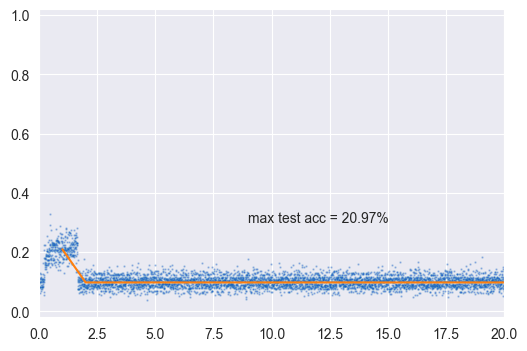

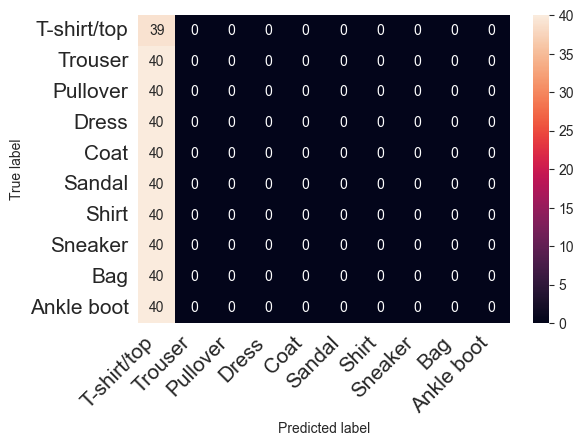

In [25]:
best_semilog_model = Model("linear/log", layer_norm=False, skip_connections=True, mu=0.9806047294630981).to(device)

print(f"{best_semilog_model.name} model has {count_parameters(best_semilog_model.parameters())} trainable parameters, "
      f"of which {count_parameters(nonsemilog_parameters(best_semilog_model))} are linear "
      f"and {count_parameters(semilog_parameters(best_semilog_model))} are semiring related")

best_semilog_linear_optimizer = torch.optim.AdamW(nonsemilog_parameters(best_semilog_model), lr=0.002191529436858294, weight_decay=0.01)
best_semilog_linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    best_semilog_linear_optimizer,
    max_lr=0.002191529436858294,
    anneal_strategy="linear",
    pct_start=0.3,
    three_phase=True,
    final_div_factor=1000.0,
    div_factor=10.0,
    steps_per_epoch=len(fmnist_trainloader),
    epochs=20,
)
best_semilog_semiring_optimizer = torch.optim.SGD(semilog_parameters(best_semilog_model), lr=0.003919415236791664)
best_semilog_semiring_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    best_semilog_semiring_optimizer,
    max_lr=0.003919415236791664,
    anneal_strategy="linear",
    pct_start=0.3,
    three_phase=True,
    final_div_factor=1000.0,
    div_factor=10.0,
    steps_per_epoch=len(fmnist_trainloader),
    epochs=20,
)

best_semilog_optimizers = [best_semilog_linear_optimizer, best_semilog_semiring_optimizer]
best_semilog_schedulers = [best_semilog_linear_scheduler]

train(
    best_semilog_model,
    fmnist_trainloader,
    fmnist_testloader,
    best_semilog_optimizers,
    best_semilog_schedulers,
    nn.CrossEntropyLoss(),
    20,
)